In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Timestamp

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

rf_rates = pd.read_csv('TB3MS.csv')

# it is giving diff rows every time,
# every time rows are increasing, maybe due to some limits of colab
NUM_ROWS = 5000000
NUM_ROWS_5M = 5000000
NUM_ROWS_600k = 600000
NUM_ROWS_1M = 1000000
df = pd.read_csv('crspm_and_predictors.csv', nrows=NUM_ROWS_1M)
df.shape # (500000, 119)

rf_rates['observation_date'] = pd.to_datetime(rf_rates['observation_date'], format='%Y-%m-%d')
df['yyyymm'] = pd.to_datetime(df['yyyymm'], format='%Y%m') #df.loc[:, 'yyyymm']

# need to be changed according to data
filtered_tb3ms = rf_rates[(rf_rates['observation_date'] >= '1990-01-01') &
                          (rf_rates['observation_date'] <= '2024-12-01')]
filtered_tb3ms.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)


#########################################################################################################
# Merge the DataFrames based on the date columns
merged_df = pd.merge(df, filtered_tb3ms, left_on='yyyymm',
                        right_on='observation_date', how='left')
merged_df.drop(columns=['observation_date'], inplace=True)
merged_df.rename(columns={'TB3MS': 'RiskFree', 'yyyymm': 'date'}, inplace=True)
print(f'after rename {merged_df.shape}')


merged_df = merged_df.replace({-np.inf: np.nan, np.inf: np.nan})
non_nan_col = merged_df[['permno', 'date']].copy()
numeric_df = merged_df.drop(columns=['permno', 'date'])
print(numeric_df.shape)
features_df = merged_df.drop(columns=['permno', 'date', 'prc', 'Price', 'ret', 'RiskFree'])
print(features_df.shape)

mask_miss_features = np.isnan(features_df)
mask_missing = np.isnan(numeric_df)

numeric_df = numeric_df.fillna(0)
merged_df = pd.concat([non_nan_col, numeric_df], axis=1)
print(f'after concat {merged_df.shape}')

#########################################################################################################
df_all_cols = merged_df.copy()
df_all_cols['ExcessReturn'] = df_all_cols['ret'] - df_all_cols['RiskFree']
df_all_cols = df_all_cols.sort_values(by='date', ascending=True).reset_index(drop=True)

df_all_cols_copy = df_all_cols.copy()

print(f'Before - checking if data is sorted {df_all_cols['date'].is_monotonic_increasing}')
# Drop unnecessary columns
df_all_cols.drop(columns=['RiskFree'], inplace=True)
print(f'After - checking if data is sorted {df_all_cols['date'].is_monotonic_increasing}')

# Extract predictor variables (excluding identifiers and return variables)
print(f'df_all_cols size {df_all_cols.columns.size}')



after rename (1000000, 120)
(1000000, 118)
(1000000, 114)
after concat (1000000, 120)
Before - checking if data is sorted True
After - checking if data is sorted True
df_all_cols size 120


In [210]:
from tabulate import tabulate

summary = {
    "Column Name": df_all_cols.columns,
}
    
summary_df = pd.DataFrame(summary)
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid"))

╒═════╤══════════════════════╕
│     │ Column Name          │
╞═════╪══════════════════════╡
│   0 │ permno               │
├─────┼──────────────────────┤
│   1 │ date                 │
├─────┼──────────────────────┤
│   2 │ prc                  │
├─────┼──────────────────────┤
│   3 │ ret                  │
├─────┼──────────────────────┤
│   4 │ Price                │
├─────┼──────────────────────┤
│   5 │ Size                 │
├─────┼──────────────────────┤
│   6 │ STreversal           │
├─────┼──────────────────────┤
│   7 │ MaxRet               │
├─────┼──────────────────────┤
│   8 │ High52               │
├─────┼──────────────────────┤
│   9 │ RealizedVol          │
├─────┼──────────────────────┤
│  10 │ IdioVol3F            │
├─────┼──────────────────────┤
│  11 │ ReturnSkew3F         │
├─────┼──────────────────────┤
│  12 │ ReturnSkew           │
├─────┼──────────────────────┤
│  13 │ IdioVolAHT           │
├─────┼──────────────────────┤
│  14 │ zerotrade1M          │
├─────┼─

In [211]:
#df_all_cols[predictor_columns].describe()



🔍 What is Target Imbalance in Regression?
In regression, imbalance means the target variable (like excess return) has a skewed or heavy-tailed distribution, where:

Most values are clustered near zero
Some rare values are extremely high or low
The model may focus too much on predicting the "typical" values and ignore the "important" tails (e.g. huge gains or losses)

✅ How to Check for Imbalance in Regression
1. Visual Inspection: Histogram or KDE Plot

👀 What to look for:

Are most values tightly packed near 0?
Are there extreme outliers on one or both sides?
Is the distribution skewed (e.g., long right tail)?

2. Summary Stats: Skewness & Kurtosis

Guidelines:

Skew > 1 or < -1 → Strong imbalance (asymmetry)
Kurtosis > 3 → Heavy tails (rare but extreme outcomes)

3. Check Quantiles

If you see:

95% of values between small bounds (like -0.02 and 0.03)
But a few in the range of -0.5 to +1.2
...then you have imbalance and long tails — which matter a lot in finance.


Why It Matters (Especially in Finance)
Predicting big up or down moves is more economically important than average cases
If your model just learns to predict "0.01" every time, it might get decent MSE — but be useless in practice
You might underperform in tail events, missing alpha opportunities or risk signals


🛠️ How to Handle Regression Imbalance
Use models that handle tails better:

Quantile regression
Gradient boosting (like XGBoost, LightGBM)
Tree-based models (they can handle non-linearity in tails)

Try log or power transforms on the target:


In [212]:
from sklearn.model_selection import train_test_split

#X = df_all_cols[predictor_columns]
#Y = df_all_cols['ExcessReturn']
#X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,1], test_size = 0.25, stratify=y.iloc[:,1], random_state = 42)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

def splitDataFrameByDateToXAndY(df_data, splitPercentile, pred_cols, Y_col):
    # assumption is df_data is already sorted
    # Find the index at 80% of the way through the data
    cutoff_idx = int(len(df_data) * splitPercentile)

    # Pick the date at that position
    cutoff_date = df_all_cols['date'].iloc[cutoff_idx]
    print(f'cutoff_date is {cutoff_date} Trainining Data would be split by < cutoff_date Test data >= cutoff_date')

    train_df = df_data[df_data['date'] < cutoff_date]
    test_df = df_data[df_data['date'] >= cutoff_date]

    X_train = train_df[pred_cols]
    Y_train = train_df[Y_col]
    X_test = test_df[pred_cols]
    Y_test = test_df[Y_col]
    return (X_train, X_test, Y_train, Y_test)


#print(f'all indexes true {df_all_cols.index == X.index == Y.index}' )


In [213]:
print("CRSP data date range:", df['yyyymm'].min(), "→", df['yyyymm'].max())
print("Merged data date range:", df_all_cols['date'].min(), "→", df_all_cols['date'].max())

print(f'After - checking if data is sorted {df_all_cols['date'].is_monotonic_increasing}')



CRSP data date range: 1960-01-01 00:00:00 → 2024-12-01 00:00:00
Merged data date range: 1960-01-01 00:00:00 → 2024-12-01 00:00:00
After - checking if data is sorted True


In [214]:
## util methods
def dropDateColIfExistsInDataFrame(X_train, X_test):
    # drop the date column before running models
    if 'date' in X_train.columns:
        X_train.drop(columns=['date'], inplace=True)
    if 'date' in X_test.columns:
        X_test.drop(columns=['date'], inplace=True)

In [215]:

def get_feature_names(model_pipeline, X_train):
    """Extract transformed feature names from a fitted pipeline."""
    from sklearn.compose import ColumnTransformer

    for step_name, step in model_pipeline.named_steps.items():
        if isinstance(step, ColumnTransformer):
            preprocessor = step
            break
    else:
        raise ValueError("No ColumnTransformer found in pipeline")

    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        if transformer == 'passthrough':
            feature_names.extend(X_train.columns[columns])
        elif hasattr(transformer, 'get_feature_names_out'):
            col_names = X_train.columns[columns] if isinstance(columns, slice) else columns
            feature_names.extend(transformer.get_feature_names_out(col_names))
        else:
            col_names = X_train.columns[columns] if isinstance(columns, slice) else columns
            feature_names.extend(col_names)

    return list(feature_names)

def get_top_features(model_pipeline, model_name, feature_names, top_n=10):
    """Extract top N features from a trained model pipeline."""
    model = model_pipeline.named_steps[list(model_pipeline.named_steps.keys())[-1]]

    if model_name in ['Linear Regression', 'ridge', 'lasso']:
        #model = model_pipeline.named_steps[list(model_pipeline.named_steps.keys())[-1]]
        coefs = model.coef_
        importances = np.abs(coefs)
    elif model_name in ['xgb', 'DecisionTree', 'RandomForest', 'GradientBoosting']:
        #model = model_pipeline.named_steps['xgbregressor']
        importances = model.feature_importances_
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    top_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    return top_df.head(top_n)


In [216]:
# Define evaluation metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline  
from sklearn.model_selection import train_test_split
import time

def prepare_models_pipeline(num_feature_cols):
    standardScaler = StandardScaler()
    minMaxScaler = MinMaxScaler(feature_range=(-1, 1))
# Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', MinMaxScaler(feature_range=(-1, 1)), slice(0, num_feature_cols))
        ]
    )

    num_components = 2
    pca = PCA(n_components=num_components)
    # 1. Linear Regression Pipeline
    lr_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), LinearRegression())

    ### 2. Ridge Regression (Regularization)
    ridge_model = Ridge(alpha=1.0)
    ridge_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), ridge_model)


    ### 3. Lasso Regression (Feature Selection)
    lasso_model = Lasso(alpha=0.01)
    lasso_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), lasso_model)

    ### 4. Random Forest (Nonlinear)
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), rf_model)

    ### 5. XGBoost (Boosting)
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), xgb_model)


    # Train all models
    models = {
        'Linear Regression': lr_pipeline,
        'ridge': ridge_pipeline,
        'lasso': lasso_pipeline,
        #'random forest': rf_pipeline,
        'xgb': xgb_pipeline
    }
    return models

from dataclasses import dataclass, asdict
from typing import Any, Optional

@dataclass
class ModelEvaluationMetric:
    run_description: Optional[str] = None
    model_name: Optional[str] = None
    r2_score: Optional[float] = None
    mean_squared_error: Optional[float] = None
    features_set: Optional[Any] = None
    run_time: Optional[float] = None

    def __str__(self):
     return f'run_description= {self.run_description}, features_set_size={len(self.features_set)}, model_name= {self.model_name}, r2_score= {self.r2_score}, mean_squared_error={self.mean_squared_error}, run_time={self.run_time} '

def plotTestAndPredictedData(model_name, Y_test, y_pred):
    plt.scatter(Y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual Excess Return")
    plt.ylabel("Predicted Excess Return")
    plt.title(f"{model_name} Regression: Actual vs Predicted")
    plt.show()

def train_models(run_description, models, X_train, X_test, Y_train, Y_test):
    modelMetricsDict = {}
    print(f'running models {models}')
    for name, model in models.items():
        print(f"\n=== Training model {name} ===")
        start_time = time.time()
        model.fit(X_train, Y_train)
        elapsed_time = time.time() - start_time
        print(f'Finished training model {name} in {elapsed_time:.2f} seconds')
        print(f"\nTop features for {name}:")
        feature_names = get_feature_names(models['Linear Regression'], X_train)
        top_features = get_top_features(model, name, feature_names)
        print(top_features)
        # Predictions
        y_pred = model.predict(X_test)
        
        # Evaluation
        print(f"\n{name} Evaluation:")
        # compare predictions y_pred with real test values Y_test

        r2_scor = r2_score(Y_test, y_pred)
        mse = mean_squared_error(Y_test, y_pred)
        modelMetrics = ModelEvaluationMetric(run_description, name, r2_scor, mse, X_train.columns.tolist(), elapsed_time)
        print(f'modelMetrics {modelMetrics}')
        plotTestAndPredictedData(name, Y_test, y_pred)
        modelMetricsDict[name] = modelMetrics
    return (run_description, modelMetricsDict, models, top_features)
   
 
# Run models with all features
predictor_columns_v1 = [col for col in df_all_cols.columns if col not in ['permno', 'ret', 'prc', 'Price', 'ExcessReturn', 'RiskFree']]
print(f'predictor_columns_v1 size {len(predictor_columns_v1)}')
X_train, X_test, Y_train, Y_test = splitDataFrameByDateToXAndY(df_all_cols, 0.8, predictor_columns_v1,  'ExcessReturn')

print(X_train['date'].is_monotonic_increasing)
print(f'first date in X_train {X_train['date'].iloc[0]} X_train size {len(X_train)}')
print(f'last date in X_train {X_train['date'].iloc[-1]} X_train size {len(X_train)}')
print(f'first date in X_test {X_test['date'].iloc[0]} X_test size {len(X_test)}')
print(f'last date in X_test {X_test['date'].iloc[-1]} X_test size {len(X_test)}')
print()
print("X_train data date range:", X_train['date'].min(), "→", X_train['date'].max())
print("X_test data date range:", X_test['date'].min(), "→", X_test['date'].max())

# drop the date column before running models
if 'date' in X_train.columns:
    X_train.drop(columns=['date'], inplace=True)
if 'date' in X_test.columns:
    X_test.drop(columns=['date'], inplace=True)
models = prepare_models_pipeline(X_train.shape[1])
v1_all_features_training = train_models('Run with All Features included ', models, X_train, X_test, Y_train, Y_test)


def splitDataSetAndRunModelsForGivenPredictorsAndGetResults(predictor_columns, df_data):
    X_train, X_test, Y_train, Y_test = splitDataFrameByDateToXAndY(df_data, 0.8, predictor_columns,  'ExcessReturn')
    print(f"splitDataSetAndRunModelsForGivenPredictors predictor_columns size {len(predictor_columns)} X_train cols sizze {len(X_train.columns)}")
    print("X_train data date range:", X_train['date'].min(), "→", X_train['date'].max())
    print("X_test data date range:", X_test['date'].min(), "→", X_test['date'].max())
    # drop the date column before running models
    if 'date' in X_train.columns:
        X_train.drop(columns=['date'], inplace=True)
    if 'date' in X_test.columns:
        X_test.drop(columns=['date'], inplace=True)
    models = prepare_models_pipeline(X_train.shape[1])
    v1_all_features_training = train_models('Run with All Features included ', models, X_train, X_test, Y_train, Y_test)
    return {
        'run_description': v1_all_features_training[0],
        'trained_models_metrics': v1_all_features_training[1],
        'top_features': v1_all_features_training[3], 
        'trained_models': v1_all_features_training[2]
    }
    


predictor_columns_v1 size 115
cutoff_date is 2011-11-01 00:00:00 Trainining Data would be split by < cutoff_date Test data >= cutoff_date
True
first date in X_train 1960-01-01 00:00:00 X_train size 799239
last date in X_train 2011-10-01 00:00:00 X_train size 799239
first date in X_test 2011-11-01 00:00:00 X_test size 200761
last date in X_test 2024-12-01 00:00:00 X_test size 200761

X_train data date range: 1960-01-01 00:00:00 → 2011-10-01 00:00:00
X_test data date range: 2011-11-01 00:00:00 → 2024-12-01 00:00:00
running models {'Linear Regression': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  slice(0, 114, None))])),
                ('pca', PCA(n_components=2)),
                ('linearregression', LinearRegression())]), 

ValueError: All arrays must be of the same length

### 📊 Linear Regression Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** Linear Regression  
**R² Score:** 0.8150  
**Mean Squared Error:** 62.6735  
**Run Time:** 69.72 seconds  

---

### 🔧 ridge Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** ridge  
**R² Score:** 0.7934  
**Mean Squared Error:** 69.9769  
**Run Time:** 23.88 seconds  

---

### 🔧 lasso Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** lasso  
**R² Score:** 0.9800  
**Mean Squared Error:** 6.7633  
**Run Time:** 79.40 seconds  

---

### ⚡ xgb Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** xgb  
**R² Score:** 0.7631  
**Mean Squared Error:** 80.2573  
**Run Time:** 57.40 seconds  


In [ ]:
table = [{k:v for k,v in asdict(r).items() if k != 'features_set'} for r in v1_all_features_training[1].values()]
print(tabulate(table, headers="keys", floatfmt=".4f", tablefmt="grid"))

def printTrainedModelMetrics(trained_models_metrics):
    table = [{k:v for k,v in asdict(r).items() if k != 'features_set'} for r in trained_models_metrics.values()]
    print(tabulate(table, headers="keys", floatfmt=".4f", tablefmt="grid"))
    

+--------------------------------+-------------------+------------+----------------------+------------+
| run_description                | model_name        |   r2_score |   mean_squared_error |   run_time |
+================================+===================+============+======================+============+
| Run with All Features included | Linear Regression |     0.8703 |              41.4294 |     9.0854 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | ridge             |     0.8703 |              41.4065 |     2.9579 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | lasso             |     0.8833 |              37.2646 |    18.1714 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | xgb               |     0.806

### First attempt results

+--------------------------------+-------------------+------------+----------------------+------------+
| run_description                | model_name        |   r2_score |   mean_squared_error |   run_time |
+================================+===================+============+======================+============+
| Run with All Features included | Linear Regression |     0.8150 |              62.6735 |    69.7220 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | ridge             |     0.7934 |              69.9769 |    23.8810 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | lasso             |     0.9800 |               6.7633 |    79.3975 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | xgb               |     0.7631 |              80.2573 |    57.3993 |
+--------------------------------+-------------------+------------+----------------------+------------+

# Likely Data Leakage

following features in your predictive models — they may contain information from the **future**, leading to **data leakage** and artificially high performance.

## 🧨 Feature Risk Table

| **Feature**             | **Why It's Risky** |
|-------------------------|--------------------|
| `AnnouncementReturn`    | Could include post-earnings announcement movement, which is only known after the fact. |
| `NumEarnIncrease`       | May be calculated over a future window of earnings, not just past — check the window. |
| `EarningsSurprise`      | ⚠️ Classic look-ahead: often uses actual earnings vs expected, which isn’t known until after quarter end. |
| `NetEquityFinance`      | Can contain forward-looking aggregated data if not lagged properly. |
| `NetDebtFinance`        | Same as above — check that it's lagged correctly. |
| `ShareIss5Y`            | May include data that isn’t known until well after the time of prediction. |
| `DebtIssuance`          | May reflect corporate actions announced or occurring after t — check time alignment. |
| `EquityDuration`        | Same as above — ensure it only uses data available at time t. |
| `ShareRepurchase`       | Can include forward-looking repurchase behavior — validate the time frame. |
| `BetaTailRisk`          | If calculated using forward return vol/skew, this leaks performance — use historical windows only. |
| `BetaLiquidityPS`       | Same as above — avoid forward-looking volatility-based calculations. |
| `betaVIX`               | Ensure it's not forward-looking — only use past data if available. |

---

## ✅ Tips to Avoid Leakage

- Always check **calculation windows** — are they backward-looking?
- Ensure that features don’t use any information that wouldn’t be available **at prediction time**.
- When in doubt, **lag** or drop the feature.

---

📌 *Want to add automated checks for leakage or build a pipeline that enforces time alignment? Let me know!*


True
True
predictor_columns_v2 size 111
cutoff_date is 2011-11-01 00:00:00 Trainining Data would be split by < cutoff_date Test data >= cutoff_date
splitDataSetAndRunModelsForGivenPredictors predictor_columns size 111 X_train cols sizze 111
X_train data date range: 1960-01-01 00:00:00 → 2011-10-01 00:00:00
X_test data date range: 2011-11-01 00:00:00 → 2024-12-01 00:00:00
running models {'Linear Regression': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 110, None))])),
                ('linearregression', LinearRegression())]), 'ridge': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 110, None))])),
                ('ridge', Ridge())]), 'lasso': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sc

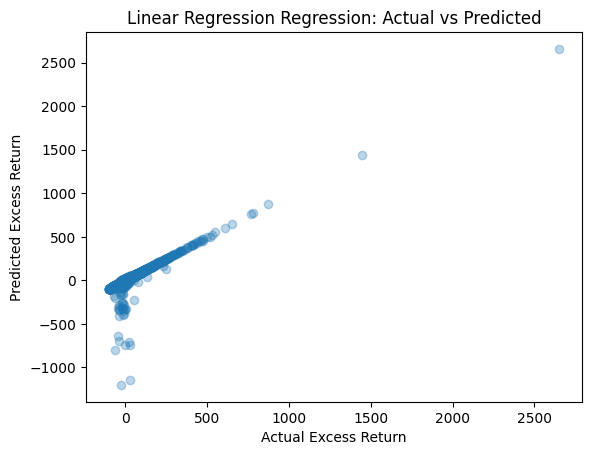


=== Training model ridge ===
Finished training model ridge in 2.90 seconds

Top features for ridge:
          feature  importance
1      STreversal   16.880865
8          DolVol    1.145038
11     Coskewness    0.353463
64           Herf    0.350394
16   zerotrade12M    0.324524
9   PriceDelayRsq    0.310447
6      IdioVolAHT    0.260842
93      HerfAsset    0.260704
30         BetaFP    0.258161
14   BidAskSpread    0.243868

ridge Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=110, model_name= ridge, r2_score= 0.858904064293017, mean_squared_error=45.06142781285009, run_time=2.9002649784088135 


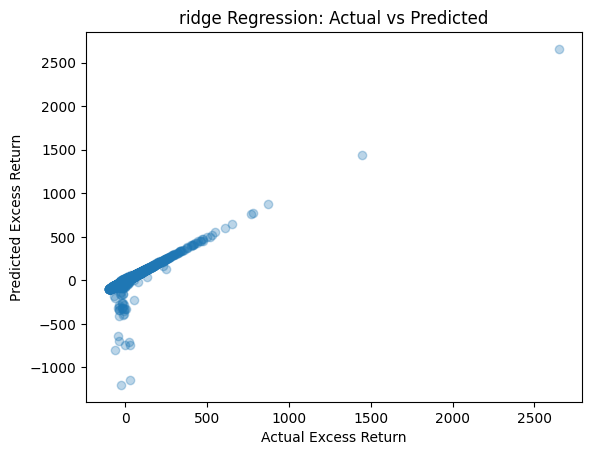


=== Training model lasso ===
Finished training model lasso in 12.18 seconds

Top features for lasso:
          feature  importance
1      STreversal   16.864345
8          DolVol    1.092470
11     Coskewness    0.344547
16   zerotrade12M    0.314539
64           Herf    0.312356
9   PriceDelayRsq    0.294446
6      IdioVolAHT    0.247349
30         BetaFP    0.245696
14   BidAskSpread    0.243255
93      HerfAsset    0.213539

lasso Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=110, model_name= lasso, r2_score= 0.8784214392680044, mean_squared_error=38.82821649372213, run_time=12.17687177658081 


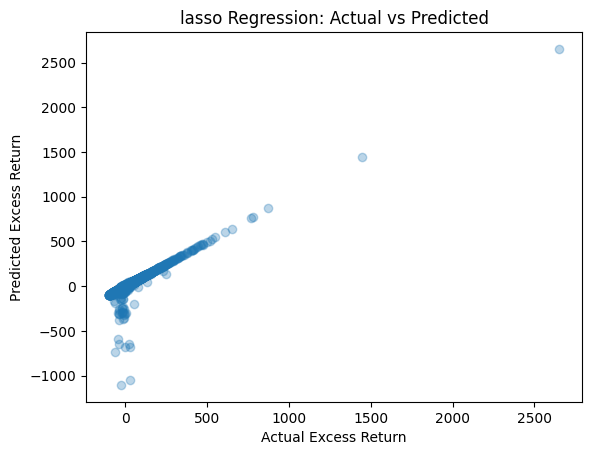


=== Training model xgb ===
Finished training model xgb in 10.76 seconds

Top features for xgb:
             feature  importance
1         STreversal    0.288986
91  AbnormalAccruals    0.054328
42        ShareIss1Y    0.049592
96     GrSaleToGrInv    0.039781
70                AM    0.034738
17              Beta    0.030322
63              dNoa    0.026185
54            DelCOL    0.025152
32            Mom12m    0.023655
41        MRreversal    0.021013

xgb Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=110, model_name= xgb, r2_score= 0.8036778829085314, mean_squared_error=62.69886416682443, run_time=10.76487398147583 


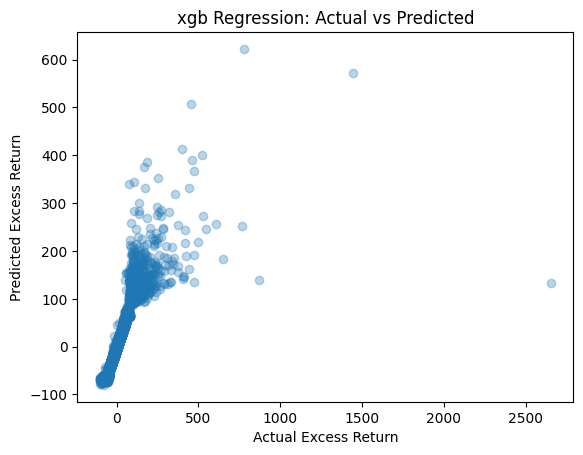

+--------------------------------+-------------------+------------+----------------------+------------+
| run_description                | model_name        |   r2_score |   mean_squared_error |   run_time |
+================================+===================+============+======================+============+
| Run with All Features included | Linear Regression |     0.8589 |              45.0614 |     8.9552 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | ridge             |     0.8589 |              45.0614 |     2.9003 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | lasso             |     0.8784 |              38.8282 |    12.1769 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | xgb               |     0.803

In [ ]:
# 🔍 A. Check correlation of EBM/BPEBM with target

df_all_cols[['EBM', 'BPEBM', 'ExcessReturn']].corr()
print('EBM' in predictor_columns_v1)
print('BPEBM' in predictor_columns_v1)


# If correlation > 0.9 — they might be leaky or overly dominant
REMOVE_PREDICTORS_V1 = ['EBM', 'BPEBM',  'IdioVol3F', 'MaxRet']

predictor_columns_v2 = [p for p in predictor_columns_v1 if p not in REMOVE_PREDICTORS_V1]

print(f"predictor_columns_v2 size {len(predictor_columns_v2)}")
trained_models_results = splitDataSetAndRunModelsForGivenPredictorsAndGetResults(predictor_columns_v2, df_all_cols)
printTrainedModelMetrics(trained_models_results['trained_models_metrics'])



In [ ]:
predictor_columns_v2

['date',
 'Size',
 'STreversal',
 'High52',
 'RealizedVol',
 'ReturnSkew3F',
 'ReturnSkew',
 'IdioVolAHT',
 'zerotrade1M',
 'DolVol',
 'PriceDelayRsq',
 'PriceDelaySlope',
 'Coskewness',
 'PriceDelayTstat',
 'zerotrade6M',
 'BidAskSpread',
 'VolMkt',
 'zerotrade12M',
 'Beta',
 'Illiquidity',
 'CoskewACX',
 'DivInit',
 'DivOmit',
 'ExchSwitch',
 'IndIPO',
 'Spinoff',
 'FirmAge',
 'IndMom',
 'Mom6m',
 'VolSD',
 'Mom12mOffSeason',
 'BetaFP',
 'MomSeasonShort',
 'Mom12m',
 'IntMom',
 'VolumeTrend',
 'ConvDebt',
 'RDIPO',
 'ShareRepurchase',
 'OPLeverage',
 'BookLeverage',
 'RoE',
 'MRreversal',
 'ShareIss1Y',
 'hire',
 'betaVIX',
 'ResidualMomentum',
 'MomSeason',
 'MomOffSeason',
 'BetaLiquidityPS',
 'ChInv',
 'DelCOA',
 'DelLTI',
 'AssetGrowth',
 'Accruals',
 'DelCOL',
 'ChNWC',
 'DelFINL',
 'DelNetFin',
 'ChNNCOA',
 'GrLTNOA',
 'Tax',
 'NOA',
 'DelEqu',
 'dNoa',
 'Herf',
 'PctAcc',
 'TotalAccruals',
 'EquityDuration',
 'LRreversal',
 'ChEQ',
 'AM',
 'CF',
 'SP',
 'Leverage',
 'XFIN',
 '

predictor_columns_v3 size 99
cutoff_date is 2011-11-01 00:00:00 Trainining Data would be split by < cutoff_date Test data >= cutoff_date
splitDataSetAndRunModelsForGivenPredictors predictor_columns size 99 X_train cols sizze 99
X_train data date range: 1960-01-01 00:00:00 → 2011-10-01 00:00:00
X_test data date range: 2011-11-01 00:00:00 → 2024-12-01 00:00:00
running models {'Linear Regression': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 98, None))])),
                ('linearregression', LinearRegression())]), 'ridge': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 98, None))])),
                ('ridge', Ridge())]), 'lasso': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', Standard

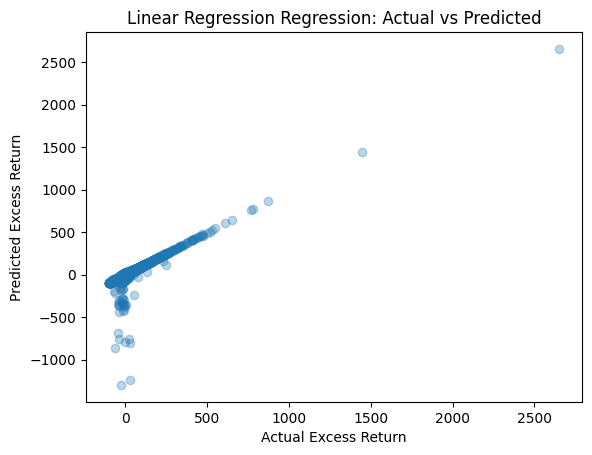


=== Training model ridge ===
Finished training model ridge in 2.87 seconds

Top features for ridge:
         feature  importance
1     STreversal   16.882503
8         DolVol    1.049059
14  zerotrade12M    0.413124
10    Coskewness    0.363506
56          Herf    0.341248
6     IdioVolAHT    0.328642
25        BetaFP    0.319097
12  BidAskSpread    0.251643
82     HerfAsset    0.250715
0           Size    0.175760

ridge Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=98, model_name= ridge, r2_score= 0.8377931304847994, mean_squared_error=51.80356971151131, run_time=2.873940944671631 


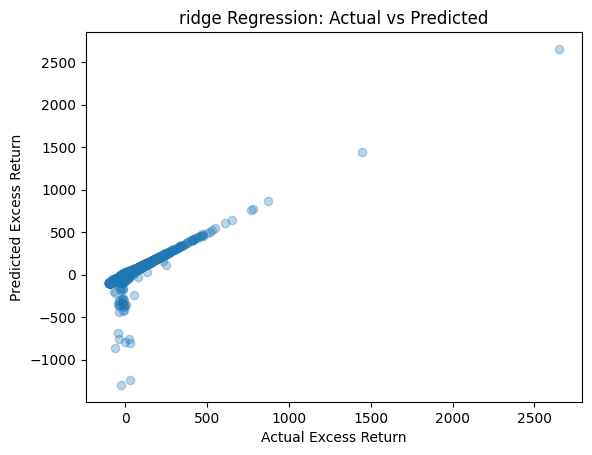


=== Training model lasso ===
Finished training model lasso in 14.15 seconds

Top features for lasso:
         feature  importance
1     STreversal   16.867001
8         DolVol    0.999216
14  zerotrade12M    0.401190
10    Coskewness    0.353440
6     IdioVolAHT    0.310668
25        BetaFP    0.304522
56          Herf    0.301587
12  BidAskSpread    0.250242
82     HerfAsset    0.202556
0           Size    0.151490

lasso Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=98, model_name= lasso, r2_score= 0.8642043195605146, mean_squared_error=43.36869960682992, run_time=14.150443077087402 


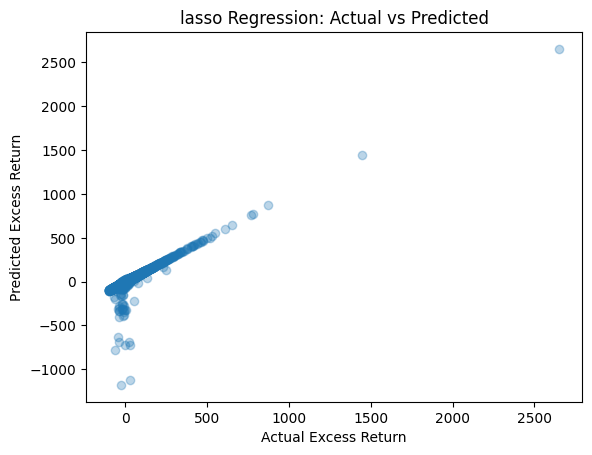


=== Training model xgb ===
Finished training model xgb in 10.60 seconds

Top features for xgb:
             feature  importance
1         STreversal    0.302966
97        CBOperProf    0.152369
85     GrSaleToGrInv    0.051565
81  AbnormalAccruals    0.046680
15              Beta    0.030680
67          CashProd    0.026195
46            DelCOL    0.020490
12      BidAskSpread    0.018827
3        RealizedVol    0.017314
2             High52    0.015838

xgb Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=98, model_name= xgb, r2_score= 0.802120988567222, mean_squared_error=63.196085306622834, run_time=10.600744009017944 


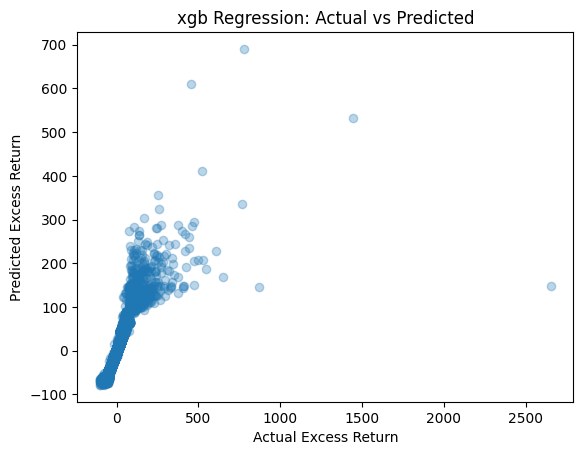

+--------------------------------+-------------------+------------+----------------------+------------+
| run_description                | model_name        |   r2_score |   mean_squared_error |   run_time |
+================================+===================+============+======================+============+
| Run with All Features included | Linear Regression |     0.8378 |              51.8034 |     6.9732 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | ridge             |     0.8378 |              51.8036 |     2.8739 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | lasso             |     0.8642 |              43.3687 |    14.1504 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | xgb               |     0.802

In [ ]:
# lets remove more precitor columns


# If correlation > 0.9 — they might be leaky or overly dominant
REMOVE_PREDICTORS_V2 = ['EarningsSurprise', 'AnnouncementReturn',  'NumEarnIncrease', 'NetEquityFinance', 'NetDebtFinance', 'ShareIss5Y',
                        'DebtIssuance', 'EquityDuration', 'EarnSupBig', 'CBOperProf']
leaky_predictors = [
    "EarningsSurprise", "AnnouncementReturn", "NumEarnIncrease",
    "NetEquityFinance", "NetDebtFinance", "DebtIssuance",
    "ShareIss5Y", "EquityDuration", "EarnSupBig", "CBOperProf"
]

leaky_columns = [
    # Too closely tied to returns
    "AnnouncementReturn",
    "EarningsSurprise",
    "RevenueSurprise",
    "MaxRet",
    "ResidualMomentum",
    "Mom12m",
    "Mom6m",
    "ShareIss1Y",
    "DebtIssuance",

    # Derived or indirect future data
    "AnalystRevision",
    "ChangeInRecommendation",
    "Recomm_ShortInterest",
    "OrderBacklogChg",
    "DivInit",
    "DivOmit",
    "SurpriseRD",
    "PredictedFE",
    "IntrinsicValue",
    "PriceDelayRsq",
    "PriceDelayTstat",

    # Placebo / Indirect (examples of potential leakage via future-constructed data)
    "AMq",
    "BMq",
    "cfpq",
    "OperProfLag",
    "OperProfLag_q",
    "OperProfRDLagAT",
    "OperProfRDLagAT_q",

    # Signal Rep Quality = 4_lack_data (incomplete, patchy, or look-ahead prone)
    "ChangeInRecommendation",
    "CredRatDG",
    "ConsRecomm",
    "DownRecomm",
    "UpRecomm"
]


predictor_columns_v3 = [p for p in predictor_columns_v2 if p not in leaky_columns]

print(f"predictor_columns_v3 size {len(predictor_columns_v3)}")
trained_models_results_v3 = splitDataSetAndRunModelsForGivenPredictorsAndGetResults(predictor_columns_v3, df_all_cols)
printTrainedModelMetrics(trained_models_results_v3['trained_models_metrics'])



In [ ]:
# Check if target or derived variables are mistakenly in predictors
print('ret' in predictor_columns_v1)
print('ExcessReturn' in predictor_columns_v1)
print('RiskFree' in predictor_columns_v1)


print('ret' in X_train.columns)
print('ExcessReturn' in X_train.columns)
print('RiskFree' in X_train.columns)

False
False
False
False
False
False


In [ ]:
# Add back ExcessReturn temporarily for correlation check
feature_check_df = df_all_cols[predictor_columns_v3 + ['ExcessReturn']].copy()
correlations = feature_check_df.corr()['ExcessReturn'].sort_values(ascending=False)

# Show most correlated features
print("Top features highly correlated with ExcessReturn:\n")
print(correlations.head(10))
# 🔍 If you see any feature with correlation > 0.9, that's suspicious.




Top features highly correlated with ExcessReturn:

ExcessReturn        1.000000
High52              0.262505
IndRetBig           0.227197
IndMom              0.031323
BM                  0.030313
Beta                0.029973
VolMkt              0.029070
CF                  0.028462
DolVol              0.027514
NetEquityFinance    0.021373
Name: ExcessReturn, dtype: float64


In [ ]:
# 3. Check for Scale Mismatch

df_all_cols[predictor_columns_v3].describe().T.sort_values(by="max", ascending=False).head(10)


TypeError: '<' not supported between instances of 'Timestamp' and 'float'

In [ ]:
features = X_train.columns.tolist()

# Check if any column is highly correlated with the target
correlations = X_train.corrwith(Y_train).sort_values(ascending=False)
print('correlations check')
print(correlations.head(10))
# If you see values very close to 1 or -1, those features may be leaking the target.



correlations check
High52                0.286044
IndRetBig             0.240286
AnnouncementReturn    0.126707
VolMkt                0.085329
DolVol                0.042825
BM                    0.040157
IndMom                0.032557
Beta                  0.030623
CF                    0.022157
MRreversal            0.020019
dtype: float64


## Print correlations:
If any predictor has correlation > 0.9 with ExcessReturn, it may be leaking target info.

In [ ]:
from sklearn.linear_model import LassoCV

# Quick Lasso with built-in CV to pick key predictors
lasso = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)

# Get non-zero coefficients
coef_df = pd.Series(lasso.coef_, index=X_train.columns)
top_features = coef_df[coef_df != 0].sort_values(key=abs, ascending=False)
print("Top predictive features:\n", top_features.head(10))


Top predictive features:
 ChInvIA             1.616191e-16
EarningsSurprise   -1.019027e-16
dtype: float64


Top predictive features:
 EarnSupBig          1.094582e-14
ChInvIA            -9.856444e-17
EarningsSurprise    3.499706e-17
dtype: float64

In [ ]:
# going to remove EarnSupBig 
print(f'check EarnSupBig in X_train columns {'EarnSupBig' in X_train.columns}')
print(f'check EarningsSurprise in X_train columns {'EarningsSurprise' in X_train.columns}')
print(f'check ChInvIA in X_train columns {'ChInvIA' in X_train.columns}')

predictor_columns_v1 = [col for col in df_all_cols.columns if col not in ['permno', 'ret', 'prc', 'Price', 'ExcessReturn', 'RiskFree']]
# X_test data date range: 2015-04-01 00:00:00 → 2024-12-01 00:00:00
# these contain dates before training you need to drop
df_all_cols_narrow = df_all_cols[df_all_cols['date'] >= '2023-01-01']
# Narrow the test set to just recent years
test_df_narrow = df_all_cols[df_all_cols['date'] >= '2023-01-01']

X_test_narrow = test_df_narrow[predictor_columns_v1]
Y_test_narrow = test_df_narrow['ExcessReturn']

# Predict with your trained lasso model
Y_pred_narrow = v1_all_features_training[2]['lasso'].predict(X_test_narrow)

from sklearn.metrics import r2_score
print("R² on recent (2023–2024) data:", r2_score(Y_test_narrow, Y_pred_narrow))




check EarnSupBig in X_train columns True
check EarningsSurprise in X_train columns True
check ChInvIA in X_train columns True
R² on recent (2023–2024) data: 0.9788919028107519
